# osmnx-matplotlib-animation

In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## 1. Load the data

In [2]:
city = gpd.read_file('data/city.json')
city.crs = "EPSG:4326"
graph = ox.load_graphml("data/graph.graphml") # street network 
districts = gpd.read_file('data/districts.json') # district shapefiles
districts.crs = "EPSG:4326"
hospitals = gpd.read_file('data/hospitals.json') # hospital locations
hospitals.crs = "EPSG:4326"

## 2. Find routes

In [3]:
# Specify origin points as hospital locations
orig_points = []
for geometry in hospitals["geometry"]:
    x, y = geometry.xy
    x = x[0]
    y = y[0]
    orig_points.append((y, x))

In [4]:
# Select a random district a destination point
n = 28
centroid = districts.iloc[n, :]['geometry'].centroid
district_name = districts.iloc[n, :]['WK_NAAM']
district = districts[districts['WK_NAAM'] == district_name]

In [5]:
# Specify destination points
x, y = centroid.xy
x = x[0]
y = y[0]
dest_points = [(y, x)] * len(orig_points)

In [6]:
# Find nearest nodes to of specified origin desination points
# Based on them make the routes
orig_nodes = []
for orig_point in orig_points:
    orig_nodes.append(ox.get_nearest_node(graph, orig_point))
    
dest_nodes = []
for dest_point in dest_points:
    dest_nodes.append(ox.get_nearest_node(graph, dest_point))

In [7]:
%%time
egs = []
for orig_node in orig_nodes:
    egs.append(nx.ego_graph(graph, orig_node, radius=2000, distance='length'))

Wall time: 213 ms


In [8]:
routes = []
lengths = []
for orig_node, dest_node in zip(orig_nodes, dest_nodes):
    try:
        routes.append(nx.shortest_path(graph, source=orig_node, target=dest_node, weight='length'))
        length = nx.shortest_path_length(G=graph, source=orig_node, target=dest_node, weight='length')
        lengths.append(length)
        print(round(length, 1))
    except:
        print('Error. No route from {} to {}.'.format(orig_node, dest_node))
        pass

print()
print('The shortest route is {} km'.format(round(min(lengths) / 1000, 1)))

3742.3
5466.1
1410.7
3742.3
4193.6

The shortest route is 1.4 km


## 3. Define route coordinates

In [9]:
# Extrat coordinates of route nodes 
route_coorindates = []

for route in routes:
    points = []
    for node_id in route:
        x = graph.nodes[node_id]['x']
        y = graph.nodes[node_id]['y']
        points.append(Point(x, y))
    route_coorindates.append(points)

In [10]:
route_gdfs = []
for p in route_coorindates:
    ids = [_ for _ in range(1, len(p) + 1)]
    points = gpd.GeoDataFrame(ids, geometry=p)
    points.crs = "EPSG:4326"
    points.columns = ['id', 'geometry']
    points.to_crs("EPSG:3395", inplace=True)
    route_gdfs.append(points)

## 4. Animate ambulance cars

In [11]:
%%time
# Project graph for plotting
projected_graph = ox.project_graph(graph, to_crs="EPSG:3395")

# Transform everything to the same coordiante system 
city.to_crs('EPSG:3395', inplace=True)
points.to_crs('EPSG:3395', inplace=True)
district = district.to_crs('EPSG:3395')
hospitals.to_crs('EPSG:3395', inplace=True)

Wall time: 12 s


In [12]:
# Fix bounds for axis
x_min, y_min, x_max, y_max = city.total_bounds

In [13]:
X = []
Y = []
for route in route_gdfs:
    x, y = route['geometry'].x.tolist(), route['geometry'].y.tolist()
    X.append(x)
    Y.append(y)

In [14]:
max_len = max([len(x) for x in X])

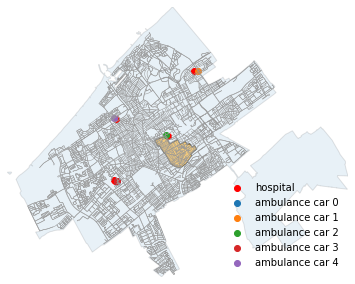

In [15]:
fig, ax = ox.plot_graph(projected_graph, node_size=0, edge_linewidth=0.5, show=False, close=False)
city.plot(ax=ax, edgecolor='black', linewidth=1, alpha=0.1)
district.plot(ax=ax, edgecolor='black', linewidth=1, alpha=0.5, color='orange', legend=True, label='vulnerable district')
hospitals.plot(ax=ax, color='red', label='hospital')
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

scatter_list = []

for j in range(len(route_gdfs)):
    scatter_list.append(ax.scatter(X[j][0], Y[j][0], label=f'ambulance car {j}'))
    
plt.legend(frameon=False)

def animate(i):
    for j in range(5):
        try:
            x_j = X[j][i]
            y_j = Y[j][i]
            scatter_list[j].set_offsets(np.c_[x_j, y_j])
        except:
            continue
            
animation = FuncAnimation(fig, animate, frames=max_len)
# HTML(animation.to_jshtml()) # to display animation in Jupyter Notebook
animation.save('animation1.mp4', dpi=300) # to save animation